In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mutual_info_score
from sklearn.decomposition import PCA
from tqdm import tqdm

datapath = './'

act_train_init = pd.read_csv(datapath + 'act_train.csv')
act_test_init = pd.read_csv(datapath +'act_test.csv')
people_init = pd.read_csv(datapath + 'people.csv')

### Let's drop the 'activity_id', 'char_10' and transorm 'date' into the date type.

In [2]:
act_train = act_train_init.drop(['activity_id', 'char_10'], axis=1)
act_train['date'] = pd.to_datetime(act_train.date)

###  As we know from Yandex.Academy lesson, this dataset has a leak (with a 'group_id' we could hit up to 0.99 roc auc. To be honest, we need to drop the 'group_1' from the people data. By the way, we could drop the date as it is unique for each 'people_id' (on the test we have different people_id).

In [3]:
people = people_init.drop(['group_1', 'date'], axis=1)

### Let's merge the training data and people data

In [4]:
train = act_train.merge(people, how='left', on='people_id')
train.head(1)

,people_id,date,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36


### Forming new dataset for analysis

In [6]:
# let's take some unique people from the people dataset
ppl_10k = people.sample(1000)
ppl_10k_id = ppl_10k.people_id

#forming new dataset by taking all info from train for unique people_id
new_set = train[train.people_id.isin(ppl_10k_id)].copy()

### Replacing NaNs and categorical features to dimmies

In [7]:
dataset = new_set

labels = dataset.outcome
features = dataset.drop(['outcome'], axis = 1)

#filling NaN in reatures with a type_0
columns = list(features.columns)
for col in columns[0:]:
    features[col] = features[col].fillna('type 0')

In [8]:
#features
categorical = features.iloc[:,2:21]
dummies = pd.get_dummies(data=categorical)

categorical_names = categorical.columns.tolist()
noncat = features.drop(categorical_names, axis = 1)

In [9]:
# replacing of True/False to 1/0

columns = list(noncat.columns)
bools = columns[2:30]

for col in bools:
    noncat[col] = pd.to_numeric(noncat[col]).astype(int)       
    
# transforming date to the separate year, month, day
noncat[['year', 'month', 'day']] = noncat.date.apply(lambda x: pd. Series( x.strftime("%Y, %m, %d").split(",")))
noncat = noncat.drop(['date', 'people_id'], axis = 1)

In [10]:
noncat.head(1)

,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,...,char_32,char_33,char_34,char_35,char_36,char_37,char_38,year,month,day
3881,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2022,08,05


### Meging preprocessed data

In [11]:
train_full = noncat.join(dummies, how = 'left')

In [12]:
print(train_full.shape)
print(labels.shape)

(11179, 283)
(11179,)


### Let's find out the labels for out dataset using GridSearch and Random Forest Classified

In [14]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(train_full, labels, test_size=num_test, random_state=7)

In [16]:
n_estimators_lin = np.arange(1,100,10)
depth_lin = np.arange(1,10,1)

reg = RandomForestClassifier()

Parameters = {'n_estimators' : n_estimators_lin,
                 'max_depth': depth_lin}

clf = GridSearchCV(reg, param_grid = Parameters, cv = 5, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)

name = reg.__class__.__name__
best_depth = clf.best_params_.get('max_depth')
best_estim = clf.best_params_.get('n_estimators')
print('The best depth parameter is',   best_depth)
print('The best number of estimators are',   best_estim)
print()

The best depth parameter is 9
The best number of estimators are 61



In [17]:
reg.set_params(n_estimators=best_estim, max_depth=best_depth)
reg.fit(X_train, y_train)
proba = clf.predict_proba(X_test)
preds = proba[:,1]
score = roc_auc_score(y_test, preds)
print("Area under ROC {0}".format(score))

Area under ROC 0.9868353821164297


###  Clastering on a full set of features with Kmeans

In [19]:
def scaling(X_train):
    scaled_features = StandardScaler().fit_transform(X_train.values)
    scaled_features_df = pd.DataFrame(scaled_features, index=X_train.index, columns=X_train.columns)
    return scaled_features_df

In [20]:
X = scaling(train_full)

/opt/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


100%|██████████| 8/8 [00:22<00:00,  2.81s/it]


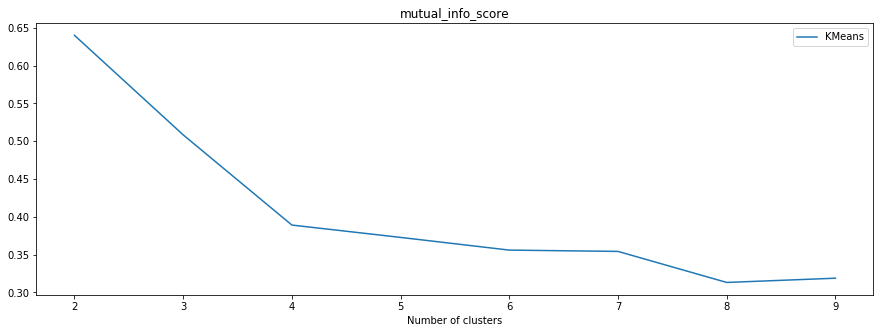

In [22]:
#let's plot the silhouette function and choose 
#proper number of clusters

numbers = list(range(2,10,1))
models = [KMeans()]

names = ['KMeans', 'Birch', 'GaussianMixture', 'MiniBatchKMeans']
scores = ['silhouette_score', 'mutual_info_score']
plt.figure(figsize = (15,5))
S = []

for cltr in  models:
    silh = []

    for n in tqdm(numbers):
        try:
            cltr.set_params(n_clusters = n)
        except:
            cltr.set_params(n_components = n)
            
        finally:
            y_pred = cltr.fit_predict(X_train)    
            silh.append(silhouette_score(X_train, y_pred))

    S.append(silh)

    
for i, score in zip(range(2), scores):
    plt.title(score)
    plt.xlabel('Number of clusters')
    for j in range(len(S)):
        if i == 0:
            plt.plot(numbers, S[j])

    plt.legend(names)
    plt.grid()

### Let's perform a PCA decomposition, then clustering and plot the results

In [24]:
pca = PCA(n_components=2)
km = KMeans(n_clusters = 2)

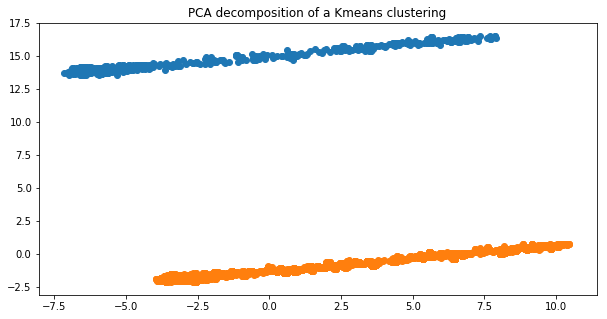

In [25]:
km.fit(X)
plot_df = X.copy()
x_train_pca = pca.fit_transform(X)
plot_df['pca_1'] = x_train_pca[:, 0]
plot_df['pca_2'] = x_train_pca[:, 1]
plot_df['cluster'] = km.predict(X)
km_pred = km.predict(X)

plt.figure(figsize=(10, 5))
for cluster, group in plot_df.groupby(['cluster']):
    plt.scatter(group.pca_1, group.pca_2)
    plt.title('PCA decomposition of a Kmeans clustering')

### Adding new feature obtained by clastering to the full dataset. Again classification and cheking new roc auc

In [28]:
train_full['cluster'] = km_pred
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(train_full, labels, test_size=num_test, random_state=23)

n_estimators_lin = np.arange(1,100,10)
depth_lin = np.arange(1,10,1)

reg = RandomForestClassifier()

Parameters = {'n_estimators' : n_estimators_lin,
                 'max_depth': depth_lin}

clf = GridSearchCV(reg, param_grid = Parameters, cv = 5, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)

name = reg.__class__.__name__
best_depth = clf.best_params_.get('max_depth')
best_estim = clf.best_params_.get('n_estimators')
print('The best depth parameter is', best_depth)
print('The best number of estimators are', best_estim)
print()

The best depth parameter is 9
The best number of estimators are 71



In [29]:
reg.set_params(n_estimators=best_estim, max_depth=best_depth)
reg.fit(X_train, y_train)
proba = clf.predict_proba(X_test)
preds = proba[:,1]
score = roc_auc_score(y_test, preds)
print("Area under ROC {0}".format(score))

Area under ROC 0.981090500731947


## Time series clustering

### Let's consider time series clustering in our dataset. We will find out how characteristics of people are changing depends on the day of week. Then, made a cluster based on that info.

In [30]:
ppl_id = new_set.people_id
date = new_set.date
numbers_scaled = scaling(train_full)

/opt/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [31]:
#PCA decomposition and new data for further analysis
pca = PCA(n_components = 2)
pca_fit = pca.fit_transform(numbers_scaled)
pca1 = pca_fit[:, 0]
pca2 = pca_fit[:, 1]

train_pca = pd.DataFrame()
train_pca['people_id'] = ppl_id
train_pca['date'] = date
train_pca['pca1'] = pca1

In [32]:
train_pca.date.iloc[0]

Timestamp('2022-08-05 00:00:00')

In [33]:
#here we are replacing exact date with a day of a week and forming
#a dataset
date_new = []
for i in range(len(train_pca)):
    date_new.append(train_pca.date.iloc[i].isoweekday())

train_pca.date = date_new

train_pca = train_pca.groupby(['people_id', 'date'], as_index = False)['pca1'].mean()

In [34]:
#reforming of dataset to time series deoendences
ppl_days = train_pca.pivot_table(values='pca1', index = 'people_id', columns='date')
means = ppl_days.mean(axis = 0)
ppl_days = ppl_days.fillna(means)
ppl_days.head(1)

date,1,2,3,4,5,6,7
people_id,,,,,,,
ppl_100620,0.402599,-0.755202,-0.652541,-0.233002,-5.602954,0.27476,0.097632


### MinMaxScaler

In [36]:
scaled_features = MinMaxScaler(feature_range=(1, 7)).fit_transform(ppl_days.values) 
scaled_features_df = pd.DataFrame(scaled_features, index=ppl_days.index, columns=ppl_days.columns)

### K means

In [37]:
X_train = scaled_features_df.copy()
X = X_train
km = KMeans(n_clusters=2)
km.fit(X)
plot_df = X.copy()
km_pred = km.predict(X)

### Let's find out the centroid of a clusters

In [38]:
ppl_indexes = scaled_features_df.index

kmeans_pred = pd.DataFrame()
kmeans_pred['people_id'] = ppl_indexes
kmeans_pred['cluster'] = km_pred

merged = train_pca.merge(kmeans_pred, how='left', on='people_id')
merged = merged.groupby(['cluster', 'date'], as_index = False)['pca1'].mean()

pivot= merged.pivot_table(values='pca1', index = 'cluster', columns='date')
pivot.head(1)

date,1,2,3,4,5,6,7
cluster,,,,,,,
0,5.93127,5.350353,6.061484,5.981326,6.343499,6.780783,6.211625


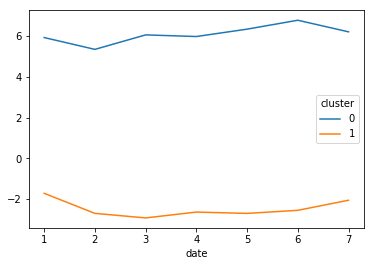

In [39]:
pivot.transpose().plot()

### Let's add new feature (result of time series clustering)

In [40]:
#addinf one column to further merging
train_full['people_id'] = ppl_id

In [41]:
# Now let's add clustering to the dataset and 
# check will it increase the roc auc or no
merged = train_full.merge(kmeans_pred, how='left', on='people_id')

In [42]:
train_full_new = merged.drop(['people_id'], axis = 1)

In [44]:
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(train_full_new, labels, test_size=num_test, random_state=23)

n_estimators_lin = np.arange(1,100,10)
depth_lin = np.arange(1,10,1)

reg = RandomForestClassifier()

Parameters = {'n_estimators' : n_estimators_lin,
                 'max_depth': depth_lin}

clf = GridSearchCV(reg, param_grid = Parameters, cv = 5, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)

name = reg.__class__.__name__
best_depth = clf.best_params_.get('max_depth')
best_estim = clf.best_params_.get('n_estimators')
print('The best depth parameter is', best_depth)
print('The best number of estimators are', best_estim)
print()

The best depth parameter is 9
The best number of estimators are 71



In [45]:
reg.set_params(n_estimators=best_estim, max_depth=best_depth)
reg.fit(X_train, y_train)
proba = clf.predict_proba(X_test)
preds = proba[:,1]
score = roc_auc_score(y_test, preds)
print("Area under ROC {0}".format(score))

Area under ROC 0.9803585537529829


### Weekly activity examples of 100 people

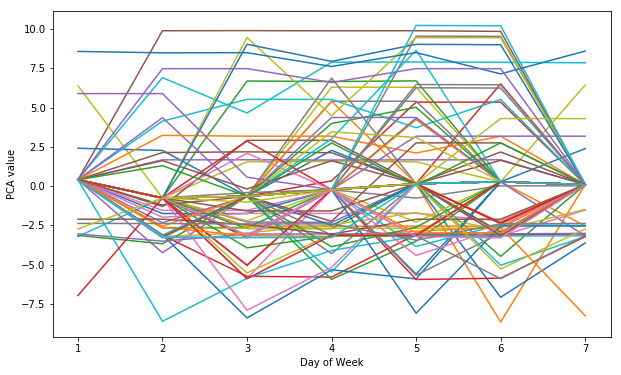

In [46]:
sep = ppl_days.iloc[0:100]
ax = sep.transpose().plot(legend = False)
ax.set_xlabel("Day of Week")
ax.set_ylabel("PCA value")
fig = plt.gcf()
fig.set_size_inches(10, 6)